# Image classification: Classify images of flowers
- Show how to classify images of flowers using a ```tf.keras.Sequential``` model and learn practical experience about efficiently loading a dataset off disk and applying techniques to handle overfitting problem including data augmentation and dropout layers.

### Import TensorFlow and necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.9.1


In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


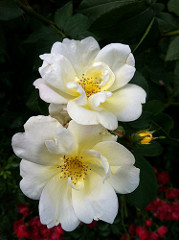

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

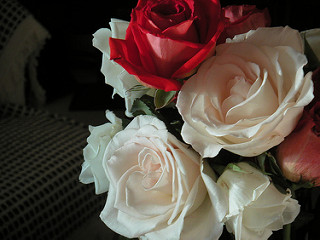

In [7]:
PIL.Image.open(str(roses[1]))

### Load data using a Keras utility
- load images off disk using ```tf.keras.utils.image_dataset_from_directory``` utility. 

In [8]:
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width)
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# find the class names (alphabetical order) in the class_names attribute
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

In [25]:
train_ds # dataset contains pairs of (image, label)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

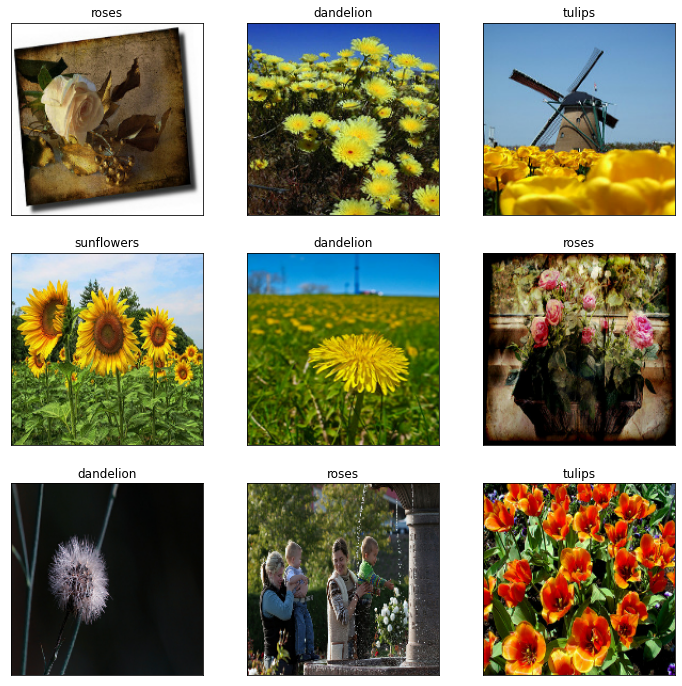

In [11]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(class_names[labels[i]])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.xticks([])
        plt.yticks([])
        
plt.show()

In [12]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape) # batch of 32 images of shape (180, 180, 3) -> (img_height, img_width, rgb color channels)
    print(label_batch.shape) # batch of 32 labels to the corresponding images 
    break

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance
- For simple description about both methods (```Dataset.cache``` and ```Dataset.prefetch```), visit [load and preprocess images tutorial](./tensorflow_keras_load_and_preprocess_images.ipynb). For more in-depth explanation about both methods and how it works when loading data, read [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [22]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255.0, input_shape=(img_height, img_width, 3)), # standardize the data
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(), # change a 3D tensor to a 1D tensor (simply unstacking rows from matrix to make a line array)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 41s 409ms/step - loss: 1.3985 - accuracy: 0.3968 - val_loss: 1.1357 - val_accuracy: 0.5136
Epoch 2/10
92/92 [==============================] - 49s 531ms/step - loss: 1.0762 - accuracy: 0.5494 - val_loss: 1.0228 - val_accuracy: 0.5872
Epoch 3/10
92/92 [==============================] - 61s 661ms/step - loss: 0.9237 - accuracy: 0.6482 - val_loss: 0.9529 - val_accuracy: 0.6226
Epoch 4/10
92/92 [==============================] - 55s 594ms/step - loss: 0.7687 - accuracy: 0.7149 - val_loss: 0.8521 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 60s 654ms/step - loss: 0.5853 - accuracy: 0.7807 - val_loss: 0.8732 - val_accuracy: 0.6649
Epoch 6/10
92/92 [==============================] - 65s 711ms/step - loss: 0.3795 - accuracy: 0.8651 - val_loss: 0.9835 - val_accuracy: 0.6608
Epoch 7/10
92/92 [==============================] - 61s 666ms/step - loss: 0.2242 - accuracy: 0.9254 - val_loss: 1.1277 - val_accuracy: 0.6540

### Visualize training results (without techniques to prevent overfitting)

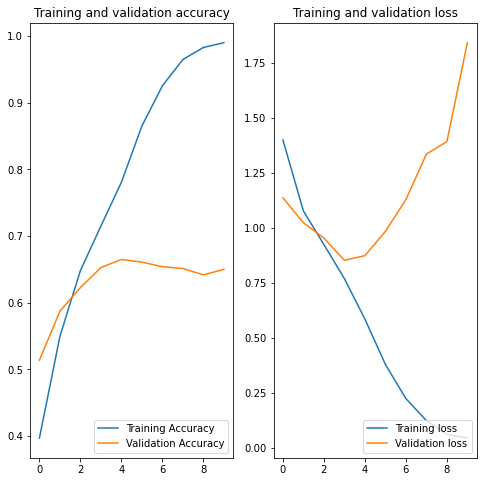

In [26]:
num_epochs = range(epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, acc, label='Training Accuracy')
plt.plot(num_epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(num_epochs, loss, label='Training loss')
plt.plot(num_epochs, val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and validation loss')

plt.show()

### Overfitting
- In the above plots, they show that the training accuracy/loss and validation accuracy/loss are off by large margin. Particularly, the difference in accuracy between training and validation is noticeable - a sign of **overfitting**.

- There are multiple ways to handle overfitting in the training process, but in this tutorial, [*data augmentation*](./tensorflow_keras_data_augmentation.ipynb) and [*dropout*](../basics/tensorflow_keras_overfit_and_underfit.ipynb) techniques will be utilized.

In [14]:
# data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

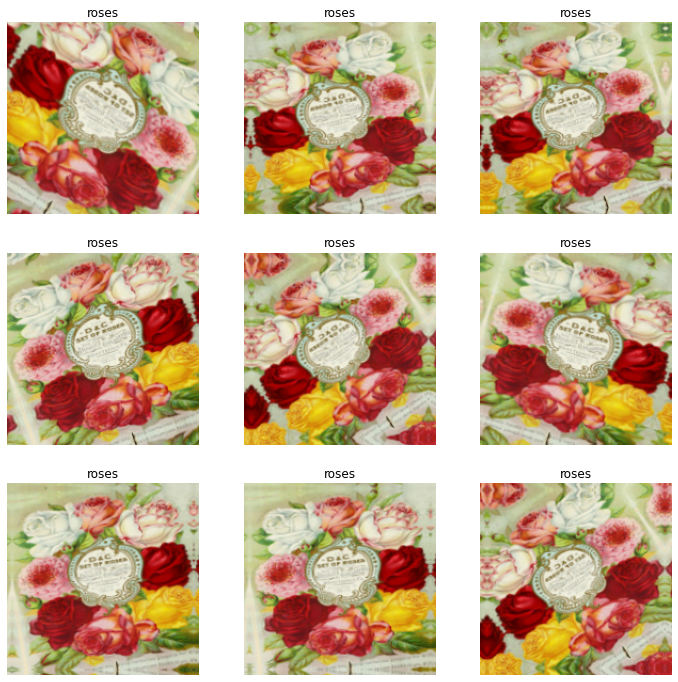

In [16]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.title(class_names[labels[0]])
        plt.axis('off')

plt.show()

In [18]:
# dropout
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1/255.0, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2), # dropout regularization
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [21]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 46s 482ms/step - loss: 1.4233 - accuracy: 0.3856 - val_loss: 1.1245 - val_accuracy: 0.5259
Epoch 2/10
92/92 [==============================] - 47s 506ms/step - loss: 1.1168 - accuracy: 0.5453 - val_loss: 1.1007 - val_accuracy: 0.5341
Epoch 3/10
92/92 [==============================] - 52s 566ms/step - loss: 1.0369 - accuracy: 0.5869 - val_loss: 0.9899 - val_accuracy: 0.6035
Epoch 4/10
92/92 [==============================] - 52s 571ms/step - loss: 0.9563 - accuracy: 0.6226 - val_loss: 0.9920 - val_accuracy: 0.6117
Epoch 5/10
92/92 [==============================] - 52s 560ms/step - loss: 0.8982 - accuracy: 0.6417 - val_loss: 0.8832 - val_accuracy: 0.6253
Epoch 6/10
92/92 [==============================] - 53s 572ms/step - loss: 0.8308 - accuracy: 0.6805 - val_loss: 0.8325 - val_accuracy: 0.6621
Epoch 7/10
92/92 [==============================] - 61s 666ms/step - loss: 0.8018 - accuracy: 0.6952 - val_loss: 0.8278 - val_accuracy: 0.6662

### Visualize training results (with techniques to prevent overfitting)

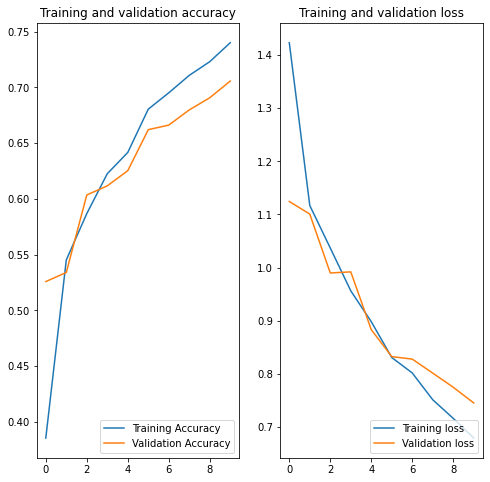

In [22]:
num_epochs = range(epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, acc, label='Training Accuracy')
plt.plot(num_epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(num_epochs, loss, label='Training loss')
plt.plot(num_epochs, val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and validation loss')

plt.show()

### Predict on new data

In [23]:
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('red_sunflower', origin=sunflower_url)

sunflower_img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(sunflower_img)
img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)

117948/117948 [==============================] - 0s 1us/step
(1, 180, 180, 3)


In [24]:
predictions = model.predict(img_array)
result = tf.nn.softmax(predictions[0])

print('This image most likely belongs to {} with a {:.2f} percent confidence.'.format(class_names[np.argmax(result)], 100*np.max(result)))

1/1 [==============================] - 0s 149ms/step
This image most likely belongs to sunflowers with a 90.80 percent confidence.
